In [1]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.utils import resample

This section plots the frame potential percentage deviation from the Haar values. First, configure the variables.

In [47]:
ansatze = 'ParallelRandom'

if ansatze == 'ParallelRandom':
    frame_potential = np.load('./results/Parallel_Random/bootstrapped_frame_potential.npy')
    samples_array = np.load('./results/Parallel_Random/samples_array.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    #qubits = [4,8,12,16,20,28,36,44,50]
    max_l = 14
    min_l = 1
    total_layer_indices = max_l
    # layers to plot for frame potential
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 400
elif ansatze == 'LocalRandom':
    frame_potential = np.load('./results/Local_Random/bootstrapped_frame_potential.npy')
    qubits = [4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48,50]
    max_l = 7
    min_l = 3
    total_layer_indices = max_l*4
    # local random plots layer to qubit ratio, which grows by 0.25 per step
    x = np.linspace(min_l, max_l, num=(max_l-min_l)*4+1)
    f_lim = [0.01, 1000]
    l_lim = 180
elif ansatze == 'HardwareEfficient':
    frame_potential = np.load('./results/Hardware_Efficient/bootstrapped_frame_potential.npy')
    qubits = [2,4,6,8,10,14,18,22,26,30,34,38,42,46,50]
    max_l = 10
    min_l=1
    total_layer_indices = max_l
    x = np.linspace(min_l, max_l, num=max_l+1-min_l)
    f_lim = [0.001, 100]
    l_lim = 120

max_n = max(qubits)
min_n = min(qubits)
colors = cm.cool(np.linspace(0, 1, max_n-min_n+1))

Actual plotting.

/tmp/ipykernel_35718/3939634330.py:1: RuntimeWarning: divide by zero encountered in log10
  mat = plt.matshow(np.log10(np.clip(samples_array[np.array(qubits)-1], 0, 500000)), cmap=plt.cm.cool, rasterized=True,)


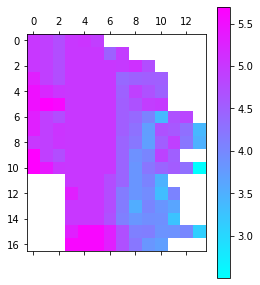

In [77]:
mat = plt.matshow(np.log10(np.clip(samples_array[np.array(qubits)-1], 0, 500000)), cmap=plt.cm.cool, rasterized=True,)
plt.colorbar(mat)
plt.savefig('parallel random samples.svg')
plt.show()

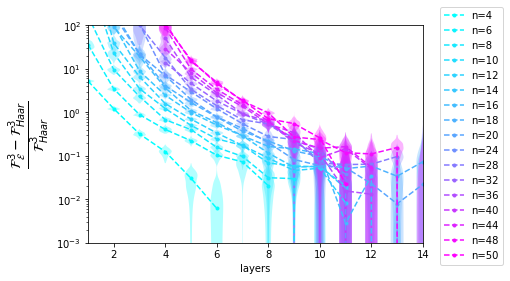

In [7]:
for k in [3]:
    haar = math.factorial(k)

    for n in qubits:
        # select the corresponding portion of the data
        if ansatze == 'LocalRandom':
            # local random plots layer to qubit ratio, which grows by 0.25 per step
            data = np.copy(frame_potential[n-1, min_l*4-1:max_l*4, k-1, :, 0]).T
        else:
            data = np.copy(frame_potential[n-1, min_l-1:max_l, k-1, :, 0]).T
        # rescaling values (mean and standard error)
        data = data/haar
        # calculate the deviation from the haar value
        data -= 1
        means = np.mean(data, axis=0)
        # only plot if there is data available for the trace
        if ~np.all(np.isnan(data)):
            plt.plot(x, means.reshape(-1), marker='.', ls='--', color=colors[n-min_n], label='n={}'.format(n))
            parts = plt.violinplot(data, showmeans=False, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(colors[n-min_n])
    
    plt.yscale('log')
    plt.ylim(f_lim[0],f_lim[1])
    plt.xlim(min(x),max(x))
    plt.xlabel('layers')
    y_label = '$\\frac{\mathcal{F}_\mathcal{E}^' + str(k) + '-\mathcal{F}_{Haar}^' + str(k) + '}{\mathcal{F}_{Haar}^' + str(k) + '}$'
    plt.ylabel(y_label, fontsize=20)
    plt.legend(loc=(1.05,-0.1))
    #plt.savefig('parallel random bootstrapped.svg')
    plt.show()

The section below estimates the number of layers needed to become $\epsilon$-approximate $k$ designs. First, a linear function and the theoretical layers needed function are defined.

In [4]:
def Linear(x, a, b):
    return a * x + b

def l_needed(n, q, epsilon):
    C = 1/(np.log((q**2+1)/(2*q)))
    return C*(2*n*np.log(q)+np.log(n)+np.log(1/epsilon))

def EXP(x, a, b):
    return a * np.exp(- b * x)

This section fits $\log{\epsilon}$ and calculates $l$.

In [44]:
from ensurepip import bootstrap


epsilon = 0.1

ks = [2,3,4,5]
min_k = min(ks)
max_k = max(ks)

# stores all the slopes of the fitted frame potential curves
all_as = []
# stores all the constant of the fitted frame potential curves
all_bs = []
# stores all the layers needed to achieve epsilon approximate k designs
all_ls = []
# stores all the numbers of qubits used
all_ns = []

qubit_increment = 2
qubits = range(min_n, max_n+1, qubit_increment)

bootstrap_samples = 300

for i in range(bootstrap_samples):
    # stores all the slopes of the fitted frame potential curves
    sample_as = []
    # stores all the constant of the fitted frame potential curves
    sample_bs = []
    # stores all the layers needed to achieve epsilon approximate k designs
    sample_ls = []
    # stores all the numbers of qubits used
    sample_ns = []
    for k in ks:
        haar = math.factorial(k)
        k_data = np.copy(frame_potential[:, :, k-1, i]) - haar
        params = None
        # stores all the numbers of qubits used for this particular k trace
        k_all_ns = []
        # stores all the fitted parameters
        all_params = []

        '''This block fits log(epsilon) as a linear curve'''
        for n in qubits:
            n_data = k_data[n-1]
            try:
                # only fit n that has data
                if ~np.all(np.isnan(n_data)):
                    # this block chooses the last layer that is not nan as the last layer, and the first layer that is not nan as the first layer (at least 3)
                    first_index = np.nan
                    last_index = np.nan
                    for index in range(total_layer_indices):
                        mean = n_data[index, 0]
                        if mean < 0 or mean > 2*haar:
                            mean = np.nan
                        if (np.isnan(first_index)) and (not np.isnan(mean)):
                            first_index = index
                            #first_index = max(first_index, 3)
                        if (np.isnan(mean)) and (not np.isnan(first_index)):
                            last_index = index-1
                            break
                    if np.isnan(last_index):
                        last_index = total_layer_indices-1
                    if np.isnan(first_index):
                        first_index = last_index - 2
                    
                    # selecting appropriate data for fitting
                    xs =  np.arange(last_index+1-first_index) + first_index + 1
                    if ansatze == 'LocalRandom':
                        # converting from index to layer/qubit ratio
                        xs = xs/4
                    ys = n_data[first_index:last_index+1, 0]
                    sigmas = n_data[first_index:last_index+1, 1]
                    # print("indices ", first_index, last_index)
                    # print("data ", xs, ys)
                    # fitting. params is fitted values, and cv is the cross correlation matrix
                    if ys.shape[0] > 2:
                        try:
                            linparams, _ = op.curve_fit(Linear, xs, np.log(ys), sigma=sigmas/ys)
                            #results, cv = op.curve_fit(EXP, xs, ys, sigma=sigmas, p0=[np.exp(linparams[1]), -linparams[0]])
                            #a = results[0]
                            #b = results[1]
                            a = np.exp(linparams[1])
                            b = -linparams[0]
                            # Calculating thelayers needed for intersecpt
                            l = (np.log(a)-2*np.log(epsilon)+2*n*k*np.log(2))/b
                            # creating correlated fitted variables
                            all_params.append(np.array([a,b,l]))
                            #print(params)
                            # indicate that this n value has results
                        except:
                            print('fit failed.')
                            all_params.append([np.nan, np.nan, np.nan])
                    else:
                        print('Valid data range too short.')
                        all_params.append([np.nan, np.nan, np.nan])
                    k_all_ns.append(n)
                    
            except:
                print(n,k)
                print(n_data)
                print(last_index, first_index)
                print(xs, ys)
                raise

        '''This block calculates the layers needed to become epsilon approximate k designs by calculating the intersect of  the fitted curves'''
        all_params = np.array(all_params)
        k_all_ns = np.array(k_all_ns)
        # update what n values have results for this k
        sample_ns.append(k_all_ns)
        # correlated epsilon slopes
        a = all_params[:,0]
        # correlated epsilon bias
        b = all_params[:,1]
        # calculating layers needed 
        l = all_params[:,2]
        # updating results to storage lists
        sample_as.append(a)
        sample_bs.append(b)
        sample_ls.append(l)
    
    all_as.append(sample_as)
    all_bs.append(sample_bs)
    all_ls.append(sample_ls)
    all_ns.append(sample_ns)

all_ls = np.array(all_ls)

Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too short.
Valid data range too

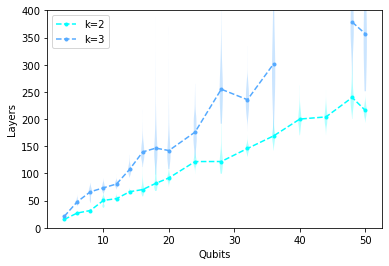

In [48]:
'''This block plots the layer scaling'''
for k in [2,3]:
    i = k-min_k
    means = np.percentile(all_ls[:, i], [50], axis=0)
    plt.plot(all_ns[0][i], means.reshape(-1), marker='.', ls='--', color=cm.cool(i/3), label='k={}'.format(k))
    parts = plt.violinplot(all_ls[:, i], all_ns[0][i], showmeans=False, showextrema=False)
    # fmt='o', ls='--', label='k='+str(k), color=cm.cool(i/3))
    for pc in parts['bodies']:
        pc.set_facecolor(cm.cool(i/3))

plt.ylim(0, l_lim)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.legend()
plt.savefig('parallel random layers needed bootstrapped.svg')
plt.show()

# # This decay rate scaling with n is only done for the hardware efficient ansatze in the manuscript
# for i, n in enumerate(all_ns[1]):
#     plt.errorbar(all_ns[1][i], -unp.nominal_values(all_uas[1][i]), yerr=unp.std_devs(all_uas[1][i]), fmt='o', color=colors[n-min_n], markersize=10)
# plt.yticks([0.5,1.0,1.5], fontsize=20)
# plt.ylabel('Decay rate', fontsize=20)
# plt.xticks([10,20,30,40,50], fontsize=20)
# plt.xlabel('k', fontsize=20)
# plt.savefig('decay_rate.pdf')
# plt.show()

For the parallel random unitary ansatze, the following analysis is done for small qubit values to establish slopes and $k$ dependence.

In [60]:
np.mean(all_ls[:, i, 1:9], axis=0)

array([ 48.28497183,  64.7843065 ,  74.00141388,  80.53703609,
       108.0563071 , 141.68666801, 159.50342792, 152.06435811])

[27.31635952 31.87503106 48.90276393 53.87910119 66.53402654 73.3877639
 87.89290574 94.0480028 ]
[ 48.28497183  64.7843065   74.00141388  80.53703609 108.0563071
 141.68666801 159.50342792 152.06435811]
[ 63.1542196   90.06359733 119.86018664 109.57601578 131.66829757
 198.01388631 329.33662295          nan]


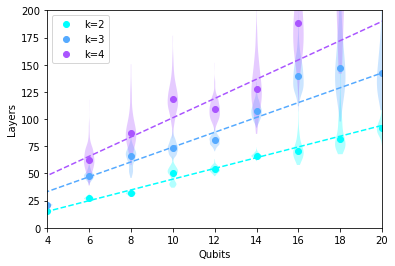

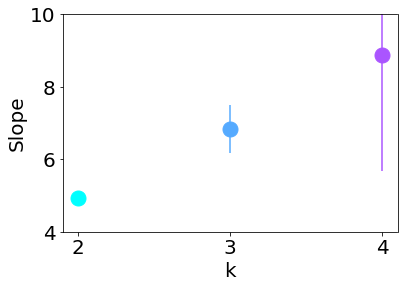

In [74]:
analytic_ns = np.linspace(1, max_n, 100)
slopes = []
slope_err = []
# plotting scaling and fitted curves for few qubits
for k in [2,3,4]:
    i = k-min_k
    means = np.percentile(all_ls[:, i], [50], axis=0)
    plt.plot(all_ns[0][i], means.reshape(-1), marker='o', ls='', color=cm.cool(i/3), label='k={}'.format(k))
    parts = plt.violinplot(all_ls[:, i], all_ns[0][i], showmeans=False, showextrema=False)
    # fmt='o', ls='--', label='k='+str(k), color=cm.cool(i/3))
    for pc in parts['bodies']:
        pc.set_facecolor(cm.cool(i/3))
    # fitting only from n=6 to 20
    print(np.mean(all_ls[:, i, 1:9], axis=0))
    params, cv = op.curve_fit(Linear, all_ns[0][i][1:9], np.nanmean(all_ls[:, i, 1:9], axis=0), sigma=np.nanstd(all_ls[:, i, 1:9], axis=0))
    slopes.append(params[0])
    slope_err.append(cv[0,0])
    plt.plot(analytic_ns, Linear(analytic_ns, params[0], params[1]), '--', color=cm.cool(i/3))

plt.xlim(4,20)
plt.ylim(0, l_lim/2)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.legend()
plt.savefig('parallel random fit bootstrapped.pdf')
plt.show()

# plot the fitted slopes
for i, k in enumerate([2,3,4]):
    plt.errorbar(k, slopes[i], yerr=slope_err[i], fmt='o', markersize=15, color=cm.cool(i/3))
plt.yticks([4,6,8,10], fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.xticks([2,3,4], fontsize=20)
plt.xlabel('k', fontsize=20)
plt.ylim(4, 10)
plt.savefig('parallel random slopes bootstrapped.pdf')
plt.show()

In [25]:
slope_err[0]

0.005001738424629436